# Single physics tutorial
A model in porepy is defined by a combination of Python classes, where each class covers its own aspect of the model.
These aspects are

* Geometry
* Equations
* Variables
* Constitutive laws
* Boundary conditions
* Solution strategy

and they are combined using multiple inheritance in Python. (go read about this)
Porepy provides complete models for several problems, and they are fully capable for running a simulation as they are. 
The user might be interested in modifying the model setup, and this is what we will cover in this tutorial.
The usual way of doing this is by overriding the pre-defined, default methods.

In this tutorial we visit how to run single physics simulations in PorePy. 
We will here solve a single phase flow problem, which is done by first covering incompressible flow.
This part includes modifying the domain, boundary conditions, and source terms. 
Towards the end of the tutorial we will modify the fluid parameters to solve the compressible flow problem.

## Running a simulation
To understand the steps of the simulation, we should understand that we will run the simulation by using the PorePy method ``run_time_dependent_model``. 
This method calls the ``Model`` methods ``prepare_simulation`` and ``after_simulation``.
A user interested in the inner workings of the model is advised to inspect these methods and possibly the submethods called therein. 

Note that the method ``run_time_dependent_model`` in the incompressible flow case is only run with one time step as this is the default time step amount.
Simulations with multiple time steps, which will be visited in more detail later, requires users to explicitly define parameters such as time step size and the time schedule.

In this tutorial, we proceed to give a more pragmatic introduction on how to use and adjust a model.
Thus, we will make use of ``run_time_dependent_model`` without any further inspections of it.

## Incompressible flow
As there already exists a model for the single phase flow problem in PorePy, running a simulation is possible with only a few lines of code.
The model can be found in the fluid_mass_balance.py file under the name ``SinglePhaseFlow``.

We start off by importing the necessary packages:

In [110]:
import porepy as pp
import numpy as np

### Geometry
The default geometry is only a unitary domain without any fractures, and we will therefore look at how to modify it. 
Here we will demonstrate how this is done by overwriting the ``set_md_grid`` method found in ``pp.ModelGeometry``. 
This is where the geometry related methods and information are found.

More specifically, we will include a diagonal fracture to our domain:

In [111]:
class ModifiedGeometry:
    def set_md_grid(self):
        # Define the domain
        self.domain = pp.Domain({"xmin": 0, "xmax": 1, "ymin": 0, "ymax": 1})

        # Generate a fracture network
        frac_1 = pp.LineFracture(np.array([[0.2, 0.8], [0.2, 0.8]]))
        fractures = [frac_1]
        fracture_network = pp.create_fracture_network(fractures, self.domain)

        # Generate the mixed-dimensional grid
        meshing_args = {"cell_size": 0.075}
        self.mdg = pp.create_mdg("simplex", meshing_args, fracture_network)

To make a new model with the modified geometry, we simply combine ``ModifiedGeometry`` with the standard model using multiple inheritance. 
Note that the modified geometry is listed _before_ the default model when creating the new one.

In [112]:
class SinglePhaseFlowGeometry(
    ModifiedGeometry,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

In order to run the simulation we make a call to ``run_time_dependent_model``, and finally we make a call to ``plot_grid`` to visualize the solution.

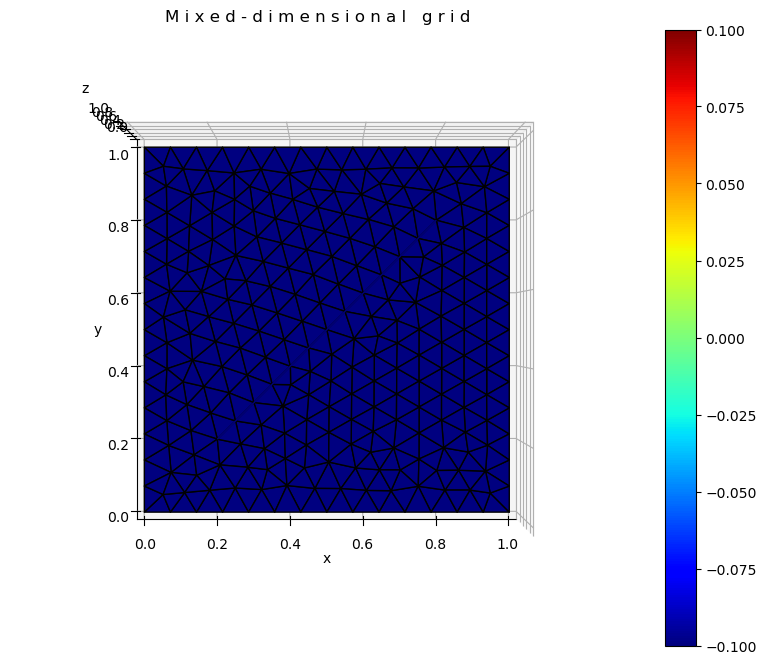

In [113]:
params = {}
model = SinglePhaseFlowGeometry(params)  
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8))

The empty `params` implies that unitary/zero default values are used for all constants.
Similarly, the default source term and boundary conditions are zero, resulting in an absence of driving forces. 
This provides us with the constant solution shown in the figure above.

### Boundary conditions, fluid and solid constants
One example of how to include some driving forces is by defining some non-zero boundary conditions. 
This is done similarly to how we modified the geometry, meaning that we will now define a mixin for the boundary conditions. 
Methods for the boundary conditions are already present in the default model class, so modifying them can be done by overwriting the methods ``bc_type_darcy`` and ``bc_values_darcy``.

In [114]:
class ModifiedBC:
    def bc_type_darcy(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign dirichlet to the west and east boundaries. The rest are Neumann by default."""
        bounds = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, bounds.west + bounds.east, "dir")
        return bc

    def bc_values_darcy(self, subdomains: list[pp.Grid]):
        """Zero bc value on top and bottom, 5 on west side, 2 on east side."""
        # Define boundary regions
        values = []
        for sd in subdomains:
            _, east, west, _, _, _, _ = self.domain_boundary_sides(sd)
            val_loc = np.zeros(sd.num_faces)
            # See section on scaling for explanation of the conversion.
            val_loc[west] = self.fluid.convert_units(5, "Pa")
            val_loc[east] = self.fluid.convert_units(2, "Pa")
            values.append(val_loc)
        return pp.wrap_as_ad_array(np.hstack(values), name="bc_values_darcy")

To combine the standard model with the new geometry _and_ the boundary conditions, we simply create a new class which inherits from all of them:

In [115]:
class SinglePhaseFlowGeometryBC(
    ModifiedGeometry,
    ModifiedBC,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

Before we go ahead and run the model, we will also have a look at how to change parameters present in the model.
Material constants are stored in and accessed through `SolidConstants` and `FluidConstants` objects.
Instantiating these classes is how we can make adjustments of the material constants. 

This is done by creating ``fluid`` and ``solid`` dictionaries inside the ``material_constants`` dictionary, which is again located within the ``params`` dictionary.
An example is shown below.

In [116]:
fluid_constants = pp.FluidConstants({"viscosity": 0.1, "density": 0.2})
solid_constants = pp.SolidConstants({"permeability": 0.5, "porosity": 0.25})
material_constants = {"fluid": fluid_constants, "solid": solid_constants}
params = {"material_constants": material_constants}


Once the fluid and solid constants are defined within the ``params`` dictionary, we feed them to the model, and then run the simulation.

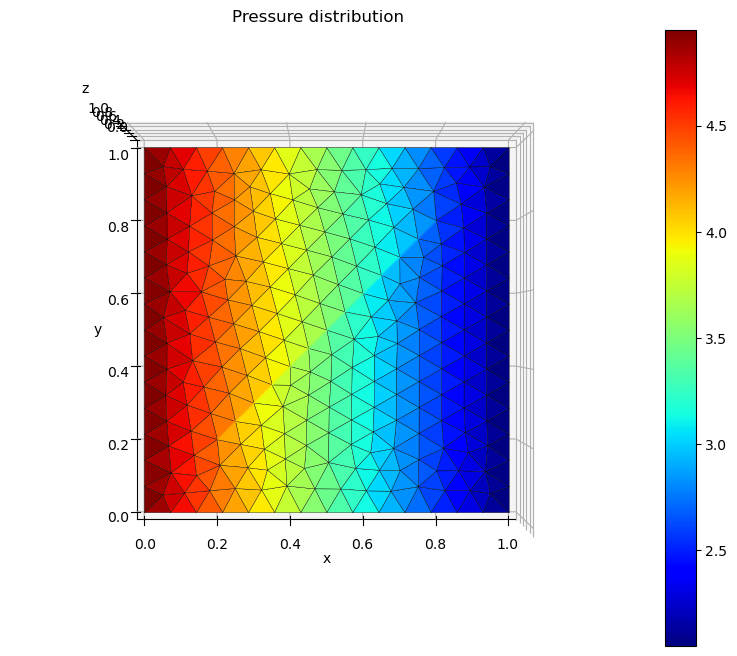

In [117]:
model = SinglePhaseFlowGeometryBC(params)
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.25, title="Pressure distribution")

#### Fracture source
Another way to modify the model is to include a fracture source.
Below we demonstrate how a unitary fracture source can be included by a rather simple modification to the method governing the fluid source

In [118]:
class ModifiedSource:
    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Assign unitary fracture source"""
        # Retrieve internal sources (jump in mortar fluxes) from the base class
        internal_sources: pp.ad.Operator = super().fluid_source(subdomains)

        # Retrieve external (integrated) sources from the exact solution.
        values = []

        for sd in subdomains:
            if sd.dim == self.mdg.dim_max():
                values.append(np.zeros(sd.num_cells))
            else:
                values.append(np.ones(sd.num_cells))

        external_sources = pp.wrap_as_ad_array(np.hstack(values))

        # Add up both contributions
        source = internal_sources + external_sources
        source.set_name("fluid sources")

        return source

For the sake of seeing the effects of the unitary fracture source, we do not include the non-zero boundary conditions.
This is simply done by not inheriting from ``ModifiedBC`` when creating the new model with a fracture source.

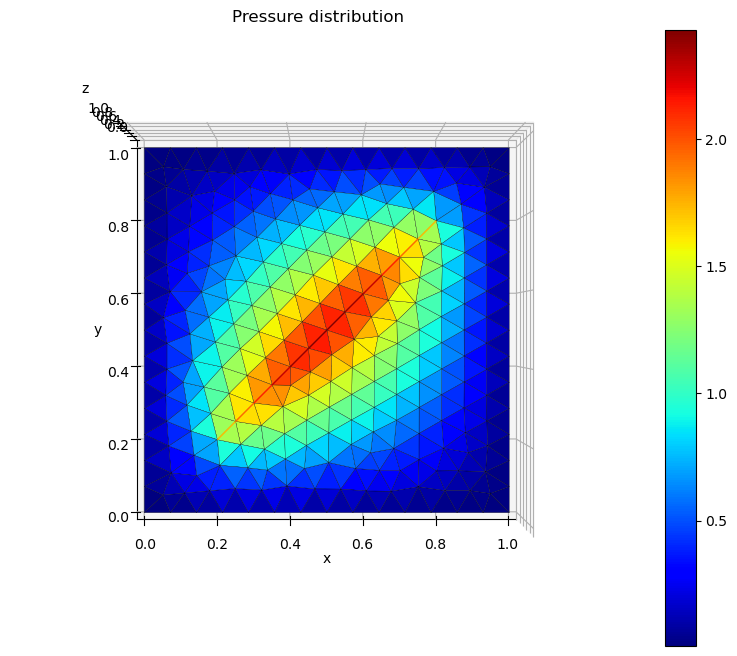

In [119]:
class SinglePhaseFlowTutorial(
    ModifiedGeometry,
    ModifiedSource,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

model = SinglePhaseFlowTutorial(params)
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.2, title="Pressure distribution")

## Compressible flow
Building upon the model with a unitary fracture source and zero boundary conditions, we will now consider a compressible fluid.
Setting the compressibility to a non-zero value makes the fluid compressible, but for seeing the gradual evolution of the solution we also need to assign non-default values to the ``pp.TimeManager``.
The time manager is passed to the model through the ``params`` dictionary, similarly to how the material constants are.

In [120]:
class SlightlyCompressibleFlow(
    ModifiedGeometry,
    ModifiedBC,
    ModifiedSource,
    pp.fluid_mass_balance.SinglePhaseFlow
):
    ...

In [121]:
fluid_constants = pp.FluidConstants({"compressibility": 0.01})
material_constants = {"fluid": fluid_constants}

time_manager = pp.TimeManager(
    schedule=[0, 1e-3],
    dt_init=1e-4,
    constant_dt=True,
    iter_max=10,
    print_info=True,
)

params = {"material_constants": material_constants, "time_manager": time_manager}
model = SlightlyCompressibleFlow(params)

Running the model and doing a simple visualization of the result is done in the exact same way as before:

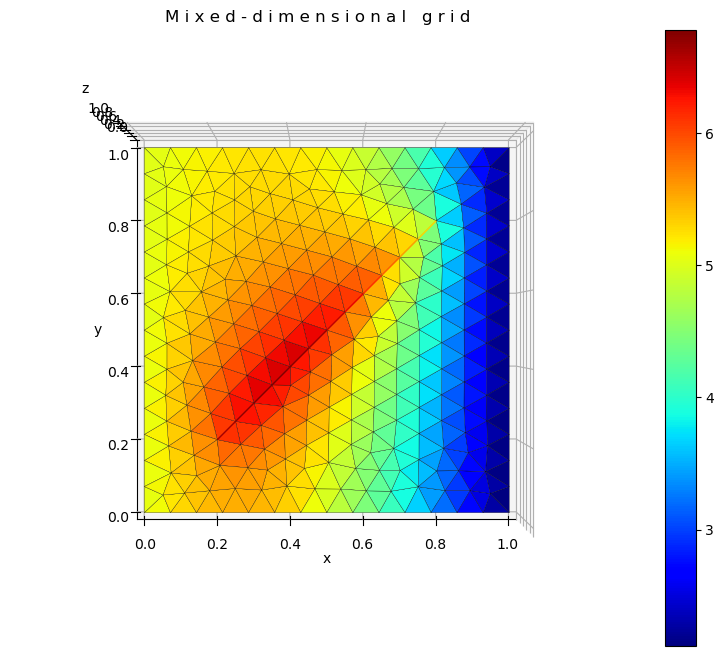

In [122]:
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.2)

The figure above shows the end solution, while the gradual evolvement of it can be visualized using e.g. ParaView.
Files for visualizing are by default saved in a folder named visualization in the working directory, see the exporter tutorial for details. TODO: add reference here


# What have we done
We have had a look at how single physics simulations can be run with PorePy by modifying various different parts of the default models.

We modified:
* Model geometry
* Boundary conditions
* Source term
* Material constants
* Time manager